In this example, we use RNN to classify names into 18 nationality categories.
Dataset: https://download.pytorch.org/tutorial/data.zip

In [1]:
import torch
import os
import random
import string

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
class NamesDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path: str, test: bool):
        xy = []
        classes = {}
        max_name_len = 0
        for i, fname in enumerate(os.listdir(dataset_path)):
            classes[i] = os.path.splitext(fname)[0]
            with open(os.path.join(dataset_path, fname), "r", encoding="utf-8") as f:
                for line in f:
                    name = line.strip().lower()
                    max_name_len = max(max_name_len, len(name))
                    xy.append((name, i))

        random.seed(42)
        random.shuffle(xy)
        
        if test:
            self.xy = xy[int(0.8*len(xy)):]
        else:
            self.xy = xy[:int(0.8*len(xy))]
        self.classes = classes
        self.max_name_len = max_name_len

    def __getitem__(self, idx):
        x_str, y_int = self.xy[idx]
        x_str = self.padding(x_str, self.max_name_len)
        x = self.name2tensor(x_str).to(device=device)
        y = torch.zeros(len(self.classes), device=device)
        y[y_int] = 1

        return x, y
    
    def __len__(self):
        return len(self.xy)
    
    @staticmethod
    def padding(x: str, target_len):
        required_padding = target_len - len(x)
        if required_padding:
            # left_pad = random.randint(0, required_padding)
            left_pad = required_padding
            right_pad = required_padding - left_pad
            x_padded = left_pad * " " + x + right_pad * " "
            assert len(x_padded)==target_len, "padding has gone wrong!"
            return x_padded
        else:
            return x

    @staticmethod
    def name2tensor(name):
        all_letters = string.ascii_letters[:26] + " "
        tensor = torch.zeros(len(name), len(all_letters))
        for i, char in enumerate(name):
            tensor[i, all_letters.find(char)] = 1
        return tensor
    
    @staticmethod
    def tensor2name(tensor):
        all_letters = string.ascii_letters[:26]  + " "
        name = ""
        for row in tensor:
            name += all_letters[row.argmax(-1).item()]
        return name

ds_train = NamesDataset(dataset_path="../datasets/names/", test=False)
ds_test = NamesDataset(dataset_path="../datasets/names/", test=True)
ds_train_loader = torch.utils.data.DataLoader(ds_train, batch_size=512, shuffle=False)
ds_test_loader = torch.utils.data.DataLoader(ds_test, batch_size=len(ds_test), shuffle=False)

In [3]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = torch.nn.Linear(input_size, hidden_size)
        self.h2h = torch.nn.Linear(hidden_size, hidden_size)
        self.h2o = torch.nn.Linear(hidden_size, output_size)
        self.softmax = torch.nn.LogSoftmax(dim=-1)
        
    def forward(self, X):
        """
        
        Args:
            X (Tensor): input tensor, shape: [nbatches, ncharacters, len_character_tensor]

        Returns:
            Tensor: output tenosr, shape: [nbatches, nclasses]
        """
        hidden = torch.zeros(X.shape[0], self.hidden_size, device=device)
        for i in range(X.shape[1]):
            x = X[:, i, :]
            hidden = torch.tanh(self.i2h(x) + self.h2h(hidden))
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output

rnn = RNNModel(27, 128, 18).to(device=device)

In [4]:
# rnn.load_state_dict(torch.load("rnn_weights.pth"))

In [6]:
lossfn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)

def train_one_batch(X, Y):
    """
    do one step training.
    Args:
        X (Tensor): input tensors.
        Y (Tensor): one-hot encoded target tensors.

    Returns:
        float: loss value.
    """
    optimizer.zero_grad()
    output = rnn(X)
    loss = lossfn(output, Y)
    loss.backward()
    optimizer.step()
    return loss.item()

def eval(X, Y):
    """
    returns the accurace of the rnn model.
    Args:
        X (Tensor): input tensors.
        Y (Tensor): one-hot encoded target tensors.
    Returns:
        float: loss, accuracy.
    """

    with torch.no_grad():
        output = rnn(X)
        val_loss = lossfn(output, Y)
        matched = (output.argmax(-1) == Y.argmax(-1))
        matched = matched.sum()
    
    accuracy = matched / X.shape[0]
    val_loss = val_loss.item()
    return val_loss, accuracy
        

In [7]:
n_epochs = 50
print("epoch\t\tbatch\t\ttraining loss\t\tval loss\t\tval accuracy")
print("----------------------------------------------------------------------------------------------")
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    train_loss.append(0)
    val_loss.append(0)
    ibatch = 0
    all_batches = len(ds_train_loader)
    for X, Y in ds_train_loader:
        ibatch += 1
        train_loss[-1] += train_one_batch(X, Y)
        print(f"{epoch+1}\t\t{ibatch}/{all_batches}\t\t{train_loss[-1]/all_batches:.2f}", end="\r")
    X, Y = next(iter(ds_test_loader))
    val_loss[-1], val_accuracy = eval(X, Y)
    train_loss[-1] /= all_batches
    print(f"{epoch+1}\t\t{ibatch}/{all_batches}\t\t{train_loss[-1]:.2f}\t\t\t{val_loss[-1]:0.2f}\t\t\t{100*val_accuracy:0.2f}%")
    if val_loss[-1] <= min(val_loss):
        torch.save(rnn.state_dict(), "rnn_weights.pth")
        

epoch		batch		training loss		val loss		val accuracy
----------------------------------------------------------------------------------------------
1		32/32		1.80			1.46			57.81%
2		32/32		1.37			1.29			63.24%
3		32/32		1.13			1.06			68.14%
4		32/32		0.98			0.96			70.61%
5		32/32		0.90			0.92			71.61%
6		32/32		0.85			0.85			73.50%
7		32/32		0.80			0.90			72.50%
8		32/32		0.79			0.80			75.67%
9		32/32		0.72			0.77			76.86%
10		32/32		0.70			0.76			77.04%
11		32/32		0.66			0.73			78.16%
12		32/32		0.64			0.71			77.93%
13		32/32		0.61			0.69			78.61%
14		32/32		0.59			0.70			79.20%
15		32/32		0.55			0.68			79.48%
16		32/32		0.53			0.68			79.33%
17		32/32		0.51			0.66			79.40%
18		32/32		0.50			0.66			79.75%
19		32/32		0.48			0.66			79.65%
20		32/32		0.46			0.70			79.08%
21		32/32		0.45			0.67			79.70%
22		32/32		0.43			0.68			79.55%
23		32/32		0.42			0.70			79.33%
24		32/32		0.40			0.72			78.73%
25		32/32		0.40			0.70			79.23%
26		32/32		0.38			0.72			78.46%
27		32/32		0.37			0.71			79.15

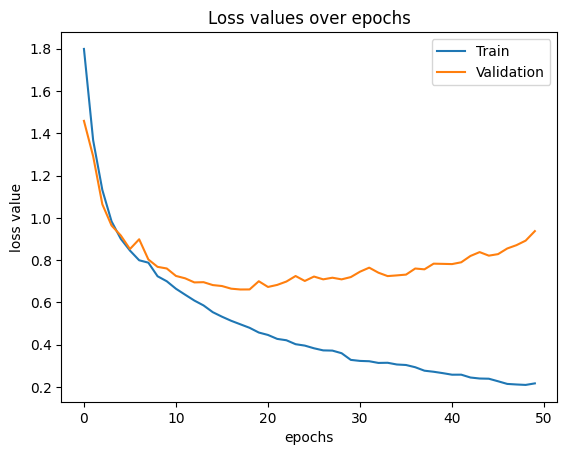

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(n_epochs), train_loss)
plt.plot(range(n_epochs), val_loss)
plt.title("Loss values over epochs")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend(["Train", "Validation"])
plt.show()


In [13]:
rnn.load_state_dict(torch.load("rnn_weights.pth"))

<All keys matched successfully>

In [14]:
import pandas as pd
with torch.no_grad():
    X, Y = next(iter(ds_test_loader))
    output = rnn(X)
    results = {"Input Name": [], "Prediction": [], "Ground-Truth": []}
    for i in range(20):
        results["Input Name"].append(ds_test.tensor2name(X[i]).strip())
        results["Prediction"].append(ds_test.classes[output[i].argmax(-1).item()])
        results["Ground-Truth"].append(ds_test.classes[Y[i].argmax(-1).item()])

df = pd.DataFrame(results)
df = df.style.set_properties(**{'text-align': 'center'})
df

,Input Name,Prediction,Ground-Truth
0,dufour,French,English
1,gorbulin,Russian,Russian
2,wheeler,German,English
3,storey,English,English
4,agakhanyan,Russian,Russian
5,hanari,Arabic,Japanese
6,vuu,Vietnamese,Vietnamese
7,amerighi,Russian,Italian
8,rahal,Arabic,Arabic
9,hennessy,English,English


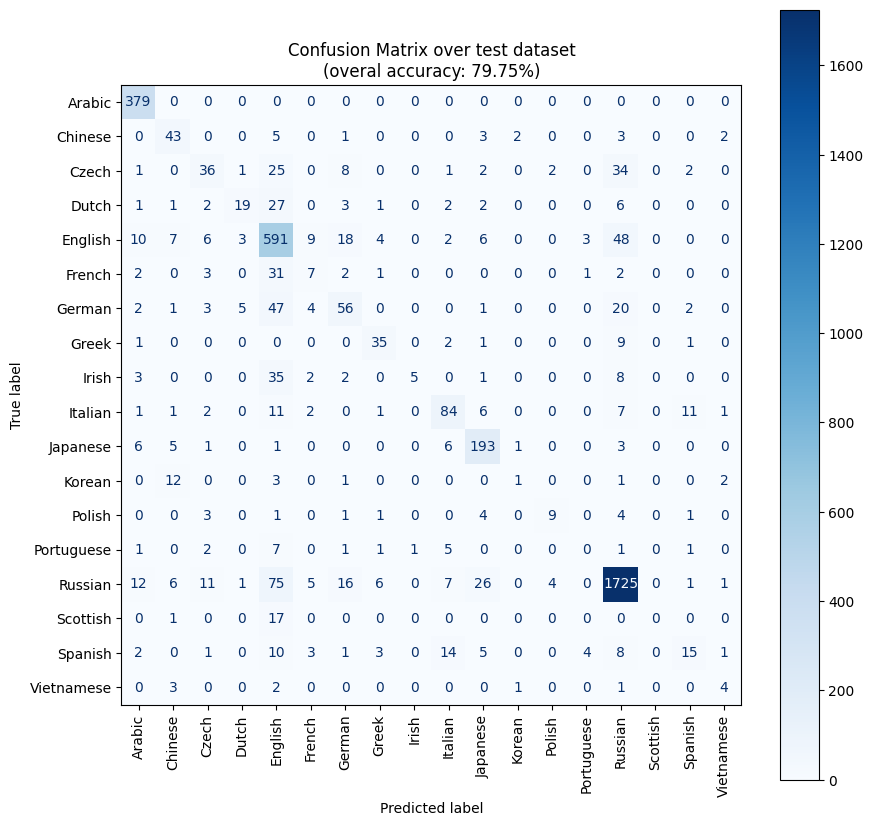

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

y_true = Y.argmax(-1).cpu().numpy()
y_pred = output.argmax(-1).cpu().numpy()
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ds_test.classes.values())
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.xticks(rotation=90)
plt.title(f"Confusion Matrix over test dataset\n(overal accuracy: {100*accuracy_score(y_true, y_pred):0.2f}%)")
plt.show()
